## benzimidazole

In [7]:
from ase.io import read
from ase.visualize import view
xyz_path_complex = 'complexes/xyz/benzimidazole.xyz'
complex_atoms = read(xyz_path_complex)
view(complex_atoms, viewer='x3d')

In [9]:
xyz_path = 'complexes/xyz/benzimidazole_hydride.xyz'
complex_hydride_atoms = read(xyz_path)
view(complex_hydride_atoms, viewer='x3d')

In [10]:
from rdkit import Chem
from rdkit.Chem import AllChem
import ase

smiles = "[nH]1cnc2ccccc12"
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)

# ---- Add 3D coords ----
AllChem.EmbedMolecule(mol, AllChem.ETKDG())
AllChem.UFFOptimizeMolecule(mol)

# ---- Your conversion function ----
def rdkit_mol_to_ase_atoms(rdkit_mol):
    conf = rdkit_mol.GetConformer()

    ase_atoms = ase.Atoms(
        numbers=[atom.GetAtomicNum() for atom in rdkit_mol.GetAtoms()],
        positions=conf.GetPositions()
    )
    return ase_atoms
ligand_atoms = rdkit_mol_to_ase_atoms(mol)
print(ligand_atoms)
view(ligand_atoms, viewer='x3d')

Atoms(symbols='NCNC6H6', pbc=False)


In [4]:
from ase import Atoms
from ase.optimize import FIRE
from ase.constraints import FixAtoms, FixCartesian
from fairchem.core import pretrained_mlip, FAIRChemCalculator
from ase.io import write
import numpy as np

# --- Step 1: Initialize FairChem calculator ---
predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cuda")
calc = FAIRChemCalculator(predictor, task_name="omol")
complex_atoms.calc = calc
# --- Step 2: Relax the complex ---
opt = FIRE(complex_atoms)
opt.run(fmax=0.1, steps=200)
E_complex = complex_atoms.get_potential_energy()
print(f"Relaxed complex energy: {E_complex:.3f} eV")
view(complex_atoms, viewer='x3d')

/home/jovyan/shared-scratch-kabdelma-pvc/kabdelma/elastic_mlps/fairchem/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/jovyan/shared-scratch-kabdelma-pvc/kabdelma/elastic_mlps/fairchem/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model fie

      Step     Time          Energy          fmax
FIRE:    0 17:37:35   -82388.633018        1.351883
FIRE:    1 17:37:35   -82388.767639        0.542354
FIRE:    2 17:37:35   -82388.764801        1.467832
FIRE:    3 17:37:35   -82388.803046        1.089336
FIRE:    4 17:37:35   -82388.842765        0.487977
FIRE:    5 17:37:35   -82388.852438        0.390983
FIRE:    6 17:37:35   -82388.854199        0.358284
FIRE:    7 17:37:36   -82388.857400        0.337410
FIRE:    8 17:37:36   -82388.861489        0.336485
FIRE:    9 17:37:36   -82388.865859        0.335427
FIRE:   10 17:37:36   -82388.870067        0.334245
FIRE:   11 17:37:36   -82388.873980        0.332840
FIRE:   12 17:37:36   -82388.877817        0.331051
FIRE:   13 17:37:36   -82388.882450        0.339414
FIRE:   14 17:37:36   -82388.888436        0.344375
FIRE:   15 17:37:36   -82388.896020        0.319695
FIRE:   16 17:37:36   -82388.904768        0.313333
FIRE:   17 17:37:37   -82388.913628        0.305654
FIRE:   18 17:

In [5]:
# --- Step 3: Energy of complex + Hydride ---
opt_ads = FIRE(complex_hydride_atoms)
complex_hydride_atoms.calc = calc
opt_ads.run(fmax=0.1, steps=200)
E_complex_hydride_atoms = complex_hydride_atoms.get_potential_energy()
print(f"Relaxed complex + hydride energy: {E_complex_hydride_atoms:.3f} eV")
view(complex_hydride_atoms, viewer='x3d')

      Step     Time          Energy          fmax
FIRE:    0 17:37:49   -72067.746396        1.204220
FIRE:    1 17:37:49   -72067.836889        0.559337
FIRE:    2 17:37:49   -72067.833992        1.281523
FIRE:    3 17:37:49   -72067.862376        0.920246
FIRE:    4 17:37:49   -72067.889867        0.353779
FIRE:    5 17:37:49   -72067.892877        0.413635
FIRE:    6 17:37:49   -72067.894225        0.377580
FIRE:    7 17:37:49   -72067.896628        0.319944
FIRE:    8 17:37:49   -72067.899574        0.288681
FIRE:    9 17:37:50   -72067.902504        0.279679
FIRE:   10 17:37:50   -72067.904993        0.268398
FIRE:   11 17:37:50   -72067.906931        0.254926
FIRE:   12 17:37:50   -72067.908577        0.255545
FIRE:   13 17:37:50   -72067.910518        0.304101
FIRE:   14 17:37:50   -72067.913191        0.307148
FIRE:   15 17:37:50   -72067.916746        0.254658
FIRE:   16 17:37:50   -72067.920689        0.158691
FIRE:   17 17:37:50   -72067.923978        0.139291
FIRE:   18 17:

In [6]:
# --- Step 5: get the energy removed ligand ---
opt_ligand = FIRE(ligand_atoms)
ligand_atoms.calc = calc
opt_ligand.run(fmax=0.1, steps=200)
E_ligand = ligand_atoms.get_potential_energy()
print(f"Relaxed ligand energy: {E_ligand:.3f} eV")

      Step     Time          Energy          fmax
FIRE:    0 17:38:20   -10336.562876        3.858701
FIRE:    1 17:38:20   -10336.838834        1.434627
FIRE:    2 17:38:21   -10336.709257        3.269362
FIRE:    3 17:38:21   -10336.803771        2.053198
FIRE:    4 17:38:21   -10336.883068        0.557039
FIRE:    5 17:38:21   -10336.871877        1.267672
FIRE:    6 17:38:21   -10336.876077        1.171834
FIRE:    7 17:38:21   -10336.883268        0.986113
FIRE:    8 17:38:21   -10336.891388        0.722829
FIRE:    9 17:38:21   -10336.898142        0.405271
FIRE:   10 17:38:21   -10336.901759        0.296216
FIRE:   11 17:38:21   -10336.901909        0.366256
FIRE:   12 17:38:22   -10336.902002        0.360850
FIRE:   13 17:38:22   -10336.902185        0.350170
FIRE:   14 17:38:22   -10336.902448        0.334436
FIRE:   15 17:38:22   -10336.902778        0.314006
FIRE:   16 17:38:22   -10336.903160        0.289374
FIRE:   17 17:38:22   -10336.903577        0.265637
FIRE:   18 17:

In [7]:
# Define the H2 molecule (A standard bond length for H2 is ~0.74 Å)
h2_molecule = Atoms("H2", positions=[[0, 0, 0], [0.74, 0, 0]])
h2_molecule.calc = calc

# Relax the H2 molecule
opt_h2 = FIRE(h2_molecule)
# Use a high fmax and fewer steps as H2 relaxation is fast
opt_h2.run(fmax=0.01, steps=100) 

E_H2 = h2_molecule.get_potential_energy()
E_H = 0.5 * E_H2
print(f"Isolated H atom energy: {E_H:.3f} eV")

      Step     Time          Energy          fmax
FIRE:    0 17:38:26      -31.589716        0.047594
FIRE:    1 17:38:26      -31.589744        0.012353
FIRE:    2 17:38:26      -31.589733        0.031729
FIRE:    3 17:38:26      -31.589737        0.025917
FIRE:    4 17:38:26      -31.589743        0.015339
FIRE:    5 17:38:26      -31.589746        0.001918
Isolated H atom energy: -15.795 eV


In [8]:
# --- Step 6: Compute adsorption energy ---
E_ads = (E_complex_hydride_atoms + E_ligand) - E_complex - E_H
print(f"Adsorption energy of H on Ni: {E_ads:.3f} eV")

Adsorption energy of H on Ni: -0.262 eV


## 2mercapto_6_methylpyridine

In [676]:
from ase.io import read
from ase.visualize import view
xyz_path_complex = 'complexes/xyz/2_mercapto_6_methylpyridine.xyz'
complex_atoms = read(xyz_path_complex)
# view(complex_atoms, viewer='x3d')

In [677]:
xyz_path = 'complexes/xyz/2_mercapto_6_methylpyridine_hydride.xyz'
complex_hydride_atoms = read(xyz_path)
# view(complex_hydride_atoms, viewer='x3d')

In [678]:
from rdkit import Chem
from rdkit.Chem import AllChem
import ase

smiles = "Cc1cccc([S-])n1"
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)

# ---- Add 3D coords ----
AllChem.EmbedMolecule(mol, AllChem.ETKDG())
AllChem.UFFOptimizeMolecule(mol)

# ---- Your conversion function ----
def rdkit_mol_to_ase_atoms(rdkit_mol):
    conf = rdkit_mol.GetConformer()

    ase_atoms = ase.Atoms(
        numbers=[atom.GetAtomicNum() for atom in rdkit_mol.GetAtoms()],
        positions=conf.GetPositions()
    )
    return ase_atoms
ligand_atoms = rdkit_mol_to_ase_atoms(mol)
print(ligand_atoms)
view(ligand_atoms, viewer='x3d')

Atoms(symbols='C6SNH6', pbc=False)


In [535]:
from ase import Atoms
from ase.optimize import FIRE
from ase.constraints import FixAtoms, FixCartesian
from fairchem.core import pretrained_mlip, FAIRChemCalculator
from ase.io import write
import numpy as np

# --- Step 1: Initialize FairChem calculator ---
predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cuda")
calc = FAIRChemCalculator(predictor, task_name="omol")
complex_atoms.calc = calc
# --- Step 2: Relax the complex ---
opt = FIRE(complex_atoms)
opt.run(fmax=0.1, steps=200)
E_complex = complex_atoms.get_potential_energy()
print(f"Relaxed complex energy: {E_complex:.3f} eV")
view(complex_atoms, viewer='x3d')

      Step     Time          Energy          fmax
FIRE:    0 19:32:49   -96977.613597        2.763788
FIRE:    1 19:32:49   -96977.905254        1.535992
FIRE:    2 19:32:49   -96978.101140        1.201376
FIRE:    3 19:32:49   -96978.182783        0.986749
FIRE:    4 19:32:50   -96978.207756        0.853204
FIRE:    5 19:32:50   -96978.247400        0.716460
FIRE:    6 19:32:50   -96978.287535        0.630787
FIRE:    7 19:32:50   -96978.319072        0.518162
FIRE:    8 19:32:50   -96978.342858        0.439604
FIRE:    9 19:32:50   -96978.365545        0.645939
FIRE:   10 19:32:50   -96978.392181        0.722229
FIRE:   11 19:32:50   -96978.427478        0.657711
FIRE:   12 19:32:50   -96978.470629        0.465248
FIRE:   13 19:32:51   -96978.518428        0.383257
FIRE:   14 19:32:51   -96978.566188        0.413336
FIRE:   15 19:32:51   -96978.610739        0.367071
FIRE:   16 19:32:51   -96978.654211        0.319223
FIRE:   17 19:32:51   -96978.697690        0.347532
FIRE:   18 19:

In [536]:
import numpy as np
from ase.optimize import FIRE
from ase.visualize import view

# ----------------------------------------------------------
# 1. Identify the metal atom
# ----------------------------------------------------------
metal_index = 0  # assume metal is atom 0
positions = complex_hydride_atoms.get_positions()
metal_pos = positions[metal_index]

# ----------------------------------------------------------
# 2. Find hydrogens bound to the metal
# ----------------------------------------------------------
hydride_indices = []
for i, atom in enumerate(complex_hydride_atoms):
    if atom.symbol == 'H':
        dist = np.linalg.norm(positions[i] - metal_pos)
        if dist < 2.0:    # typical M–H bond length cutoff
            hydride_indices.append(i)

print("Hydrides attached to metal:", hydride_indices)

# ----------------------------------------------------------
# 3. Remove one hydrogen (if there are two)
# ----------------------------------------------------------
if len(hydride_indices) > 1:
    remove_index = hydride_indices[1]  # remove second hydride
    complex_hydride_atoms.pop(remove_index)
    print(f"Removed hydrogen index {remove_index}")

# ----------------------------------------------------------
# 4. Run optimization with the calculator
# ----------------------------------------------------------
complex_hydride_atoms.calc = calc

opt = FIRE(complex_hydride_atoms)
opt.run(fmax=0.1, steps=200)

E_complex_hydride_atoms = complex_hydride_atoms.get_potential_energy()
print(f"Relaxed energy (single hydride): {E_relaxed:.3f} eV")
view(complex_hydride_atoms, viewer='x3d')


Hydrides attached to metal: [29, 30]
Removed hydrogen index 30
      Step     Time          Energy          fmax
FIRE:    0 19:32:53   -78347.716632        3.368866
FIRE:    1 19:32:53   -78348.056199        2.623341
FIRE:    2 19:32:53   -78348.298269        1.062060
FIRE:    3 19:32:53   -78348.320452        1.216154
FIRE:    4 19:32:53   -78348.346043        1.076753
FIRE:    5 19:32:54   -78348.386733        0.820299
FIRE:    6 19:32:54   -78348.427599        0.568481
FIRE:    7 19:32:54   -78348.457652        0.536869
FIRE:    8 19:32:54   -78348.475285        0.519217
FIRE:    9 19:32:54   -78348.486440        0.606435
FIRE:   10 19:32:54   -78348.498130        0.696225
FIRE:   11 19:32:54   -78348.516761        0.766204
FIRE:   12 19:32:54   -78348.544816        0.710025
FIRE:   13 19:32:54   -78348.580604        0.521197
FIRE:   14 19:32:55   -78348.617793        0.399172
FIRE:   15 19:32:55   -78348.647539        0.275671
FIRE:   16 19:32:55   -78348.667317        0.483118
FIR

In [538]:
# # --- Step 3: Energy of complex + Hydride ---
# opt_ads = FIRE(complex_hydride_atoms)
# complex_hydride_atoms.calc = calc
# opt_ads.run(fmax=0.1, steps=200)
# E_complex_hydride_atoms = complex_hydride_atoms.get_potential_energy()
# print(f"Relaxed complex + hydride energy: {E_complex_hydride_atoms:.3f} eV")
# view(complex_hydride_atoms, viewer='x3d')

In [539]:
# --- Step 5: get the energy removed ligand ---
opt_ligand = FIRE(ligand_atoms)
ligand_atoms.info.update({"charge": -1})
ligand_atoms.calc = calc
opt_ligand.run(fmax=0.1, steps=200)
E_ligand = ligand_atoms.get_potential_energy()
print(f"Relaxed ligand energy: {E_ligand:.3f} eV")

      Step     Time          Energy          fmax
FIRE:    0 19:32:57   -18645.892820        2.435317
FIRE:    1 19:32:57   -18645.997520        1.217423
FIRE:    2 19:32:57   -18645.994786        1.483368
FIRE:    3 19:32:57   -18646.016698        1.063128
FIRE:    4 19:32:57   -18646.040824        0.679697
FIRE:    5 19:32:57   -18646.048138        0.440924
FIRE:    6 19:32:57   -18646.048761        0.409048
FIRE:    7 19:32:57   -18646.049898        0.347523
FIRE:    8 19:32:57   -18646.051363        0.309897
FIRE:    9 19:32:57   -18646.052939        0.304931
FIRE:   10 19:32:58   -18646.054448        0.297449
FIRE:   11 19:32:58   -18646.055804        0.286614
FIRE:   12 19:32:58   -18646.057040        0.271772
FIRE:   13 19:32:58   -18646.058391        0.250492
FIRE:   14 19:32:58   -18646.059999        0.248263
FIRE:   15 19:32:58   -18646.061914        0.223774
FIRE:   16 19:32:58   -18646.063960        0.147797
FIRE:   17 19:32:58   -18646.065734        0.152645
FIRE:   18 19:

In [540]:
# Define the H2 molecule (A standard bond length for H2 is ~0.74 Å)
h2_molecule = Atoms("H2", positions=[[0, 0, 0], [0.74, 0, 0]])
h2_molecule.calc = calc

# Relax the H2 molecule
opt_h2 = FIRE(h2_molecule)
# Use a high fmax and fewer steps as H2 relaxation is fast
opt_h2.run(fmax=0.01, steps=100) 

E_H2 = h2_molecule.get_potential_energy()
E_H = 0.5 * E_H2
print(f"Isolated H atom energy: {E_H:.3f} eV")

      Step     Time          Energy          fmax
FIRE:    0 19:32:59      -31.589716        0.047594
FIRE:    1 19:33:00      -31.589744        0.012353
FIRE:    2 19:33:00      -31.589733        0.031727
FIRE:    3 19:33:00      -31.589737        0.025917
FIRE:    4 19:33:00      -31.589743        0.015339
FIRE:    5 19:33:00      -31.589746        0.001920
Isolated H atom energy: -15.795 eV


In [542]:
# --- Step 6: Compute adsorption energy ---
E_ads = (E_complex_hydride_atoms + E_ligand) - E_complex - E_H
print(f"Adsorption energy of H on Ni: {E_ads:.3f} eV")

Adsorption energy of H on Ni: -0.194 eV


## 6_mercaptonicotinonitrile

In [550]:
from ase.io import read
from ase.visualize import view
xyz_path_complex = 'complexes/xyz/6_mercaptonicotinonitrile.xyz'
complex_atoms = read(xyz_path_complex)
# view(complex_atoms, viewer='x3d')

In [551]:
xyz_path = 'complexes/xyz/6_mercaptonicotinonitrile_hydride.xyz'
complex_hydride_atoms = read(xyz_path)
# view(complex_hydride_atoms, viewer='x3d')

In [552]:
from ase import Atoms
from ase.optimize import FIRE
from ase.constraints import FixAtoms, FixCartesian
from fairchem.core import pretrained_mlip, FAIRChemCalculator
from ase.io import write
import numpy as np

# --- Step 1: Initialize FairChem calculator ---
predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cuda")
calc = FAIRChemCalculator(predictor, task_name="omol")
complex_atoms.calc = calc
# --- Step 2: Relax the complex ---
opt = FIRE(complex_atoms)
opt.run(fmax=0.1, steps=200)
E_complex = complex_atoms.get_potential_energy()
print(f"Relaxed complex energy: {E_complex:.3f} eV")
view(complex_atoms, viewer='x3d')

      Step     Time          Energy          fmax
FIRE:    0 19:34:51  -101294.972240       10.848197
FIRE:    1 19:34:51  -101297.796215        6.117557
FIRE:    2 19:34:51  -101299.140939        2.666852
FIRE:    3 19:34:51  -101299.546505        1.936128
FIRE:    4 19:34:51  -101299.632270        1.491448
FIRE:    5 19:34:51  -101299.710386        1.201913
FIRE:    6 19:34:51  -101299.780962        1.840360
FIRE:    7 19:34:52  -101299.886109        0.953519
FIRE:    8 19:34:52  -101299.964743        0.804357
FIRE:    9 19:34:52  -101300.021014        1.457276
FIRE:   10 19:34:52  -101300.103615        0.803249
FIRE:   11 19:34:52  -101300.182636        0.923957
FIRE:   12 19:34:52  -101300.274619        1.353607
FIRE:   13 19:34:52  -101300.400643        0.836092
FIRE:   14 19:34:52  -101300.514926        1.193262
FIRE:   15 19:34:52  -101300.653263        1.036654
FIRE:   16 19:34:53  -101300.802378        0.512388
FIRE:   17 19:34:53  -101300.920188        1.331785
FIRE:   18 19:

In [553]:
from rdkit import Chem
from rdkit.Chem import AllChem
import ase

smiles = "C1=CC(=S)[N-]C=C1C#N"
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)

# ---- Add 3D coords ----
AllChem.EmbedMolecule(mol, AllChem.ETKDG())
AllChem.UFFOptimizeMolecule(mol)

# ---- Your conversion function ----
def rdkit_mol_to_ase_atoms(rdkit_mol):
    conf = rdkit_mol.GetConformer()

    ase_atoms = ase.Atoms(
        numbers=[atom.GetAtomicNum() for atom in rdkit_mol.GetAtoms()],
        positions=conf.GetPositions()
    )
    return ase_atoms
ligand_atoms = rdkit_mol_to_ase_atoms(mol)
print(ligand_atoms)
view(ligand_atoms, viewer='x3d')

Atoms(symbols='C3SNC3NH3', pbc=False)


In [554]:
import numpy as np
from ase.optimize import FIRE
from ase.visualize import view

# ----------------------------------------------------------
# 1. Identify the metal atom
# ----------------------------------------------------------
metal_index = 0  # assume metal is atom 0
positions = complex_hydride_atoms.get_positions()
metal_pos = positions[metal_index]

# ----------------------------------------------------------
# 2. Find hydrogens bound to the metal
# ----------------------------------------------------------
hydride_indices = []
for i, atom in enumerate(complex_hydride_atoms):
    if atom.symbol == 'H':
        dist = np.linalg.norm(positions[i] - metal_pos)
        if dist < 2.0:    # typical M–H bond length cutoff
            hydride_indices.append(i)

print("Hydrides attached to metal:", hydride_indices)

# ----------------------------------------------------------
# 3. Remove one hydrogen (if there are two)
# ----------------------------------------------------------
if len(hydride_indices) > 1:
    remove_index = hydride_indices[1]  # remove second hydride
    complex_hydride_atoms.pop(remove_index)
    print(f"Removed hydrogen index {remove_index}")

# ----------------------------------------------------------
# 4. Run optimization with the calculator
# ----------------------------------------------------------
complex_hydride_atoms.calc = calc

opt = FIRE(complex_hydride_atoms)
opt.run(fmax=0.1, steps=200)

E_complex_hydride_atoms = complex_hydride_atoms.get_potential_energy()
print(f"Relaxed energy (single hydride): {E_relaxed:.3f} eV")
view(complex_hydride_atoms, viewer='x3d')


Hydrides attached to metal: [25, 26]
Removed hydrogen index 26
      Step     Time          Energy          fmax
FIRE:    0 19:35:01   -81225.773836       13.390210
FIRE:    1 19:35:01   -81228.237651        4.775156
FIRE:    2 19:35:01   -81228.867849        1.971797
FIRE:    3 19:35:01   -81228.928050        1.641556
FIRE:    4 19:35:02   -81228.991383        1.109942
FIRE:    5 19:35:02   -81229.036609        1.326654
FIRE:    6 19:35:02   -81229.082499        1.000789
FIRE:    7 19:35:02   -81229.127552        1.131342
FIRE:    8 19:35:02   -81229.177550        1.026424
FIRE:    9 19:35:02   -81229.235708        0.916454
FIRE:   10 19:35:02   -81229.288132        0.768265
FIRE:   11 19:35:02   -81229.347952        0.944360
FIRE:   12 19:35:02   -81229.417700        0.540675
FIRE:   13 19:35:03   -81229.473522        0.841597
FIRE:   14 19:35:03   -81229.539206        0.940543
FIRE:   15 19:35:03   -81229.616145        0.545884
FIRE:   16 19:35:03   -81229.673231        0.749422
FIR

In [548]:
# # --- Step 3: Energy of complex + Hydride ---
# opt_ads = FIRE(complex_hydride_atoms)
# complex_hydride_atoms.calc = calc
# opt_ads.run(fmax=0.05, steps=200)
# E_complex_hydride_atoms = complex_hydride_atoms.get_potential_energy()
# print(f"Relaxed complex + hydride energy: {E_complex_hydride_atoms:.3f} eV")
# view(complex_hydride_atoms, viewer='x3d')

## The hydrogens get desorped

In [555]:
# --- Step 5: get the energy removed ligand ---
opt_ligand = FIRE(ligand_atoms)
ligand_atoms.info.update({"charge": -1})
ligand_atoms.calc = calc
opt_ligand.run(fmax=0.1, steps=200)
E_ligand = ligand_atoms.get_potential_energy()
print(f"Relaxed ligand energy: {E_ligand:.3f} eV")

      Step     Time          Energy          fmax
FIRE:    0 19:35:34   -20087.397354        2.810424
FIRE:    1 19:35:34   -20087.576368        0.898232
FIRE:    2 19:35:34   -20087.498796        2.941411
FIRE:    3 19:35:34   -20087.557726        1.962237
FIRE:    4 19:35:35   -20087.607661        0.555158
FIRE:    5 19:35:35   -20087.601367        1.099718
FIRE:    6 19:35:35   -20087.603804        1.033355
FIRE:    7 19:35:35   -20087.608011        0.904330
FIRE:    8 19:35:35   -20087.612856        0.720208
FIRE:    9 19:35:35   -20087.617067        0.493480
FIRE:   10 19:35:35   -20087.619648        0.248922
FIRE:   11 19:35:35   -20087.620330        0.263612
FIRE:   12 19:35:35   -20087.620386        0.262313
FIRE:   13 19:35:35   -20087.620495        0.259753
FIRE:   14 19:35:36   -20087.620654        0.255952
FIRE:   15 19:35:36   -20087.620856        0.250987
FIRE:   16 19:35:36   -20087.621093        0.244929
FIRE:   17 19:35:36   -20087.621355        0.237900
FIRE:   18 19:

In [556]:
# Define the H2 molecule (A standard bond length for H2 is ~0.74 Å)
h2_molecule = Atoms("H2", positions=[[0, 0, 0], [0.74, 0, 0]])
h2_molecule.calc = calc

# Relax the H2 molecule
opt_h2 = FIRE(h2_molecule)
# Use a high fmax and fewer steps as H2 relaxation is fast
opt_h2.run(fmax=0.01, steps=100) 

E_H2 = h2_molecule.get_potential_energy()
E_H = 0.5 * E_H2
print(f"Isolated H atom energy: {E_H:.3f} eV")

      Step     Time          Energy          fmax
FIRE:    0 19:35:39      -31.589716        0.047594
FIRE:    1 19:35:39      -31.589744        0.012353
FIRE:    2 19:35:39      -31.589733        0.031727
FIRE:    3 19:35:39      -31.589737        0.025917
FIRE:    4 19:35:40      -31.589743        0.015339
FIRE:    5 19:35:40      -31.589746        0.001920
Isolated H atom energy: -15.795 eV


In [558]:
# --- Step 6: Compute adsorption energy ---
E_ads = (E_complex_hydride_atoms + E_ligand) - E_complex - E_H
print(f"Adsorption energy of H on Ni: {E_ads:.3f} eV")

Adsorption energy of H on Ni: -0.649 eV


## 3_bromo_6_mercaptopyridine

In [559]:
from ase.io import read
from ase.visualize import view
xyz_path_complex = 'complexes/xyz/3_bromo_6_mercaptopyridine.xyz'
complex_atoms = read(xyz_path_complex)
# view(complex_atoms, viewer='x3d')

In [560]:
xyz_path = 'complexes/xyz/3_bromo_6_mercaptopyridine_hydride.xyz'
complex_hydride_atoms = read(xyz_path)
# view(complex_hydride_atoms, viewer='x3d')

In [561]:
from ase import Atoms
from ase.optimize import FIRE
from ase.constraints import FixAtoms, FixCartesian
from fairchem.core import pretrained_mlip, FAIRChemCalculator
from ase.io import write
import numpy as np

# --- Step 1: Initialize FairChem calculator ---
predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cuda")
calc = FAIRChemCalculator(predictor, task_name="omol")
complex_atoms.calc = calc
# --- Step 2: Relax the complex ---
opt = FIRE(complex_atoms)
opt.run(fmax=0.1, steps=200)
E_complex = complex_atoms.get_potential_energy()
print(f"Relaxed complex energy: {E_complex:.3f} eV")
view(complex_atoms, viewer='x3d')

      Step     Time          Energy          fmax
FIRE:    0 19:36:31  -303842.046948       10.947763
FIRE:    1 19:36:31  -303844.966680        6.056933
FIRE:    2 19:36:31  -303846.256682        2.608957
FIRE:    3 19:36:31  -303846.664360        1.516570
FIRE:    4 19:36:31  -303846.569608        1.978639
FIRE:    5 19:36:31  -303846.642074        1.886199
FIRE:    6 19:36:32  -303846.760485        1.700233
FIRE:    7 19:36:32  -303846.892491        1.422179
FIRE:    8 19:36:32  -303847.020035        1.067903
FIRE:    9 19:36:32  -303847.136118        0.791253
FIRE:   10 19:36:32  -303847.230263        0.716322
FIRE:   11 19:36:32  -303847.295292        0.751231
FIRE:   12 19:36:32  -303847.348901        1.155876
FIRE:   13 19:36:32  -303847.415569        1.381503
FIRE:   14 19:36:32  -303847.507215        1.309309
FIRE:   15 19:36:32  -303847.620655        0.997405
FIRE:   16 19:36:33  -303847.766004        0.939205
FIRE:   17 19:36:33  -303847.922069        0.720738
FIRE:   18 19:

In [562]:
from rdkit import Chem
from rdkit.Chem import AllChem
import ase

smiles = "C1=CC(=S)[N-]C=C1Br"
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)

# ---- Add 3D coords ----
AllChem.EmbedMolecule(mol, AllChem.ETKDG())
AllChem.UFFOptimizeMolecule(mol)

# ---- Your conversion function ----
def rdkit_mol_to_ase_atoms(rdkit_mol):
    conf = rdkit_mol.GetConformer()

    ase_atoms = ase.Atoms(
        numbers=[atom.GetAtomicNum() for atom in rdkit_mol.GetAtoms()],
        positions=conf.GetPositions()
    )
    return ase_atoms
ligand_atoms = rdkit_mol_to_ase_atoms(mol)
print(ligand_atoms)
view(ligand_atoms, viewer='x3d')

Atoms(symbols='C3SNC2BrH3', pbc=False)


In [564]:
import numpy as np
from ase.optimize import FIRE
from ase.visualize import view

# ----------------------------------------------------------
# 1. Identify the metal atom
# ----------------------------------------------------------
metal_index = 0  # assume metal is atom 0
positions = complex_hydride_atoms.get_positions()
metal_pos = positions[metal_index]

# ----------------------------------------------------------
# 2. Find hydrogens bound to the metal
# ----------------------------------------------------------
hydride_indices = []
for i, atom in enumerate(complex_hydride_atoms):
    if atom.symbol == 'H':
        dist = np.linalg.norm(positions[i] - metal_pos)
        if dist < 2.0:    # typical M–H bond length cutoff
            hydride_indices.append(i)

print("Hydrides attached to metal:", hydride_indices)

# ----------------------------------------------------------
# 3. Remove one hydrogen (if there are two)
# ----------------------------------------------------------
if len(hydride_indices) > 1:
    remove_index = hydride_indices[1]  # remove second hydride
    complex_hydride_atoms.pop(remove_index)
    print(f"Removed hydrogen index {remove_index}")

# ----------------------------------------------------------
# 4. Run optimization with the calculator
# ----------------------------------------------------------
complex_hydride_atoms.calc = calc

opt = FIRE(complex_hydride_atoms)
opt.run(fmax=0.1, steps=200)

E_complex_hydride_atoms = complex_hydride_atoms.get_potential_energy()
print(f"Relaxed energy (single hydride): {E_relaxed:.3f} eV")
view(complex_hydride_atoms, viewer='x3d')


Hydrides attached to metal: [23, 24]
Removed hydrogen index 24
      Step     Time          Energy          fmax
FIRE:    0 19:36:58  -216257.164430       13.377674
FIRE:    1 19:36:58  -216259.652493        4.708706
FIRE:    2 19:36:58  -216260.252673        1.780843
FIRE:    3 19:36:58  -216260.292800        1.515581
FIRE:    4 19:36:58  -216260.350652        1.099722
FIRE:    5 19:36:58  -216260.403652        0.938084
FIRE:    6 19:36:58  -216260.448547        0.957493
FIRE:    7 19:36:59  -216260.494944        0.998095
FIRE:    8 19:36:59  -216260.546358        0.994285
FIRE:    9 19:36:59  -216260.598161        0.902565
FIRE:   10 19:36:59  -216260.654057        0.753080
FIRE:   11 19:36:59  -216260.717521        0.562622
FIRE:   12 19:36:59  -216260.783186        0.583725
FIRE:   13 19:36:59  -216260.843900        0.637640
FIRE:   14 19:36:59  -216260.913976        0.495715
FIRE:   15 19:36:59  -216260.985033        0.683211
FIRE:   16 19:36:59  -216261.055169        0.574048
FIR

In [563]:
# # --- Step 3: Energy of complex + Hydride ---
# opt_ads = FIRE(complex_hydride_atoms)
# complex_hydride_atoms.calc = calc
# opt_ads.run(fmax=0.1, steps=200)
# E_complex_hydride_atoms = complex_hydride_atoms.get_potential_energy()
# print(f"Relaxed complex + hydride energy: {E_complex_hydride_atoms:.3f} eV")
# view(complex_hydride_atoms, viewer='x3d')

## the hydrogens got detached

In [565]:
# --- Step 5: get the energy removed ligand ---
opt_ligand = FIRE(ligand_atoms)
ligand_atoms.info.update({"charge": -1})
ligand_atoms.calc = calc
opt_ligand.run(fmax=0.1, steps=200)
E_ligand = ligand_atoms.get_potential_energy()
print(f"Relaxed ligand energy: {E_ligand:.3f} eV")

      Step     Time          Energy          fmax
FIRE:    0 19:37:14   -87602.760405        2.803504
FIRE:    1 19:37:14   -87602.916583        1.126023
FIRE:    2 19:37:14   -87602.884400        2.193429
FIRE:    3 19:37:14   -87602.917965        1.531588
FIRE:    4 19:37:15   -87602.950855        0.618696
FIRE:    5 19:37:15   -87602.954491        0.770109
FIRE:    6 19:37:15   -87602.955641        0.726102
FIRE:    7 19:37:15   -87602.957667        0.641117
FIRE:    8 19:37:15   -87602.960099        0.521314
FIRE:    9 19:37:15   -87602.962405        0.376473
FIRE:   10 19:37:15   -87602.964159        0.243265
FIRE:   11 19:37:15   -87602.965218        0.257722
FIRE:   12 19:37:15   -87602.965802        0.287806
FIRE:   13 19:37:15   -87602.966391        0.361262
FIRE:   14 19:37:16   -87602.967423        0.379282
FIRE:   15 19:37:16   -87602.969142        0.331072
FIRE:   16 19:37:16   -87602.971308        0.218595
FIRE:   17 19:37:16   -87602.973124        0.140687
FIRE:   18 19:

In [566]:
# Define the H2 molecule (A standard bond length for H2 is ~0.74 Å)
h2_molecule = Atoms("H2", positions=[[0, 0, 0], [0.74, 0, 0]])
h2_molecule.calc = calc

# Relax the H2 molecule
opt_h2 = FIRE(h2_molecule)
# Use a high fmax and fewer steps as H2 relaxation is fast
opt_h2.run(fmax=0.01, steps=100) 

E_H2 = h2_molecule.get_potential_energy()
E_H = 0.5 * E_H2
print(f"Isolated H atom energy: {E_H:.3f} eV")

      Step     Time          Energy          fmax
FIRE:    0 19:37:18      -31.589716        0.047594
FIRE:    1 19:37:18      -31.589744        0.012353
FIRE:    2 19:37:18      -31.589733        0.031727
FIRE:    3 19:37:19      -31.589737        0.025916
FIRE:    4 19:37:19      -31.589743        0.015339
FIRE:    5 19:37:19      -31.589746        0.001920
Isolated H atom energy: -15.795 eV


In [568]:
# --- Step 6: Compute adsorption energy ---
E_ads = (E_complex_hydride_atoms + E_ligand) - E_complex - E_H
print(f"Adsorption energy of H on Ni: {E_ads:.3f} eV")

Adsorption energy of H on Ni: -0.297 eV


## 3_aminopyridine_2_1H_thione

In [569]:
from ase.io import read
from ase.visualize import view
xyz_path_complex = 'complexes/xyz/3_aminopyridine_2_1H_thione.xyz'
complex_atoms = read(xyz_path_complex)
# view(complex_atoms, viewer='x3d')

In [570]:
xyz_path = 'complexes/xyz/3_aminopyridine_2_1H_thione_hydride.xyz'
complex_hydride_atoms = read(xyz_path)
# view(complex_hydride_atoms, viewer='x3d')

In [571]:
from ase import Atoms
from ase.optimize import FIRE
from ase.constraints import FixAtoms, FixCartesian
from fairchem.core import pretrained_mlip, FAIRChemCalculator
from ase.io import write
import numpy as np

# --- Step 1: Initialize FairChem calculator ---
predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cuda")
calc = FAIRChemCalculator(predictor, task_name="omol")
complex_atoms.calc = calc
# --- Step 2: Relax the complex ---
opt = FIRE(complex_atoms)
opt.run(fmax=0.1, steps=200)
E_complex = complex_atoms.get_potential_energy()
print(f"Relaxed complex energy: {E_complex:.3f} eV")
view(complex_atoms, viewer='x3d')

      Step     Time          Energy          fmax
FIRE:    0 19:37:55   -98282.452753       11.019243
FIRE:    1 19:37:55   -98285.474189        6.152983
FIRE:    2 19:37:55   -98286.799888        2.564188
FIRE:    3 19:37:55   -98287.144245        1.473762
FIRE:    4 19:37:55   -98287.186537        1.385269
FIRE:    5 19:37:56   -98287.255891        1.212748
FIRE:    6 19:37:56   -98287.332560        0.968095
FIRE:    7 19:37:56   -98287.404447        0.682498
FIRE:    8 19:37:56   -98287.470275        0.664813
FIRE:    9 19:37:56   -98287.533246        0.648899
FIRE:   10 19:37:56   -98287.595936        0.727204
FIRE:   11 19:37:56   -98287.668409        0.933209
FIRE:   12 19:37:56   -98287.757122        0.973972
FIRE:   13 19:37:56   -98287.866308        0.798635
FIRE:   14 19:37:57   -98287.990243        0.461360
FIRE:   15 19:37:57   -98288.122494        0.531617
FIRE:   16 19:37:57   -98288.260851        0.522386
FIRE:   17 19:37:57   -98288.394436        0.685836
FIRE:   18 19:

In [572]:
from rdkit import Chem
from rdkit.Chem import AllChem
import ase

smiles = "C1=C[N-]C(=S)C(=C1)N"
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)

# ---- Add 3D coords ----
AllChem.EmbedMolecule(mol, AllChem.ETKDG())
AllChem.UFFOptimizeMolecule(mol)

# ---- Your conversion function ----
def rdkit_mol_to_ase_atoms(rdkit_mol):
    conf = rdkit_mol.GetConformer()

    ase_atoms = ase.Atoms(
        numbers=[atom.GetAtomicNum() for atom in rdkit_mol.GetAtoms()],
        positions=conf.GetPositions()
    )
    return ase_atoms
ligand_atoms = rdkit_mol_to_ase_atoms(mol)
print(ligand_atoms)
view(ligand_atoms, viewer='x3d')

Atoms(symbols='C2NCSC2NH5', pbc=False)


In [574]:
import numpy as np
from ase.optimize import FIRE
from ase.visualize import view

# ----------------------------------------------------------
# 1. Identify the metal atom
# ----------------------------------------------------------
metal_index = 0  # assume metal is atom 0
positions = complex_hydride_atoms.get_positions()
metal_pos = positions[metal_index]

# ----------------------------------------------------------
# 2. Find hydrogens bound to the metal
# ----------------------------------------------------------
hydride_indices = []
for i, atom in enumerate(complex_hydride_atoms):
    if atom.symbol == 'H':
        dist = np.linalg.norm(positions[i] - metal_pos)
        if dist < 2.0:    # typical M–H bond length cutoff
            hydride_indices.append(i)

print("Hydrides attached to metal:", hydride_indices)

# ----------------------------------------------------------
# 3. Remove one hydrogen (if there are two)
# ----------------------------------------------------------
if len(hydride_indices) > 1:
    remove_index = hydride_indices[1]  # remove second hydride
    complex_hydride_atoms.pop(remove_index)
    print(f"Removed hydrogen index {remove_index}")

# ----------------------------------------------------------
# 4. Run optimization with the calculator
# ----------------------------------------------------------
complex_hydride_atoms.calc = calc

opt = FIRE(complex_hydride_atoms)
opt.run(fmax=0.1, steps=200)

E_complex_hydride_atoms = complex_hydride_atoms.get_potential_energy()
print(f"Relaxed energy (single hydride): {E_relaxed:.3f} eV")
view(complex_hydride_atoms, viewer='x3d')


Hydrides attached to metal: [27, 28]
Removed hydrogen index 28
      Step     Time          Energy          fmax
FIRE:    0 19:38:28   -79217.423978       13.307969
FIRE:    1 19:38:29   -79220.003862        4.723763
FIRE:    2 19:38:29   -79220.646916        1.538682
FIRE:    3 19:38:29   -79220.687187        1.344955
FIRE:    4 19:38:29   -79220.746425        1.044088
FIRE:    5 19:38:29   -79220.802028        0.949407
FIRE:    6 19:38:29   -79220.849352        0.946914
FIRE:    7 19:38:29   -79220.898068        0.966390
FIRE:    8 19:38:29   -79220.953694        0.957628
FIRE:    9 19:38:29   -79221.012188        0.883367
FIRE:   10 19:38:29   -79221.075334        0.737641
FIRE:   11 19:38:29   -79221.144919        0.644393
FIRE:   12 19:38:30   -79221.221677        0.614971
FIRE:   13 19:38:30   -79221.300383        0.669493
FIRE:   14 19:38:30   -79221.386557        0.542625
FIRE:   15 19:38:30   -79221.475957        0.458175
FIRE:   16 19:38:30   -79221.555910        0.499039
FIR

In [573]:
# # --- Step 3: Energy of complex + Hydride ---
# opt_ads = FIRE(complex_hydride_atoms)
# complex_hydride_atoms.calc = calc
# opt_ads.run(fmax=0.1, steps=200)
# E_complex_hydride_atoms = complex_hydride_atoms.get_potential_energy()
# print(f"Relaxed complex + hydride energy: {E_complex_hydride_atoms:.3f} eV")
# view(complex_hydride_atoms, viewer='x3d')

## the hydrogens got desorped

In [575]:
# --- Step 5: get the energy removed ligand ---
opt_ligand = FIRE(ligand_atoms)
ligand_atoms.info.update({"charge": -1})
ligand_atoms.calc = calc
opt_ligand.run(fmax=0.1, steps=200)
E_ligand = ligand_atoms.get_potential_energy()
print(f"Relaxed ligand energy: {E_ligand:.3f} eV")

      Step     Time          Energy          fmax
FIRE:    0 19:38:50   -19082.638623        2.958243
FIRE:    1 19:38:50   -19082.861478        1.240572
FIRE:    2 19:38:50   -19082.867168        2.064575
FIRE:    3 19:38:50   -19082.897882        1.483803
FIRE:    4 19:38:50   -19082.934950        0.869482
FIRE:    5 19:38:50   -19082.953129        0.647022
FIRE:    6 19:38:51   -19082.952397        1.466955
FIRE:    7 19:38:51   -19082.954899        1.386326
FIRE:    8 19:38:51   -19082.959403        1.230414
FIRE:    9 19:38:51   -19082.965033        1.009869
FIRE:   10 19:38:51   -19082.970778        0.740502
FIRE:   11 19:38:51   -19082.975772        0.583715
FIRE:   12 19:38:51   -19082.979595        0.563361
FIRE:   13 19:38:51   -19082.982462        0.542711
FIRE:   14 19:38:51   -19082.985350        0.520970
FIRE:   15 19:38:51   -19082.989238        0.499134
FIRE:   16 19:38:52   -19082.995049        0.521602
FIRE:   17 19:38:52   -19083.002985        0.456373
FIRE:   18 19:

In [576]:
# Define the H2 molecule (A standard bond length for H2 is ~0.74 Å)
h2_molecule = Atoms("H2", positions=[[0, 0, 0], [0.74, 0, 0]])
h2_molecule.calc = calc

# Relax the H2 molecule
opt_h2 = FIRE(h2_molecule)
# Use a high fmax and fewer steps as H2 relaxation is fast
opt_h2.run(fmax=0.01, steps=100) 

E_H2 = h2_molecule.get_potential_energy()
E_H = 0.5 * E_H2
print(f"Isolated H atom energy: {E_H:.3f} eV")

      Step     Time          Energy          fmax
FIRE:    0 19:38:54      -31.589716        0.047594
FIRE:    1 19:38:54      -31.589744        0.012353
FIRE:    2 19:38:54      -31.589733        0.031727
FIRE:    3 19:38:54      -31.589737        0.025917
FIRE:    4 19:38:54      -31.589743        0.015339
FIRE:    5 19:38:54      -31.589746        0.001920
Isolated H atom energy: -15.795 eV


In [578]:
# --- Step 6: Compute adsorption energy ---
E_ads = (E_complex_hydride_atoms + E_ligand) - E_complex - E_H
print(f"Adsorption energy of H on Ni: {E_ads:.3f} eV")

Adsorption energy of H on Ni: -0.008 eV


## 5_chloropyridine_2_thiol

In [579]:
from ase.io import read
from ase.visualize import view
xyz_path_complex = 'complexes/xyz/5_chloropyridine_2_thiol.xyz'
complex_atoms = read(xyz_path_complex)
# view(complex_atoms, viewer='x3d')

In [580]:
xyz_path = 'complexes/xyz/5_chloropyridine_2_thiol_hydride.xyz'
complex_hydride_atoms = read(xyz_path)
# view(complex_hydride_atoms, viewer='x3d')

In [581]:
from ase import Atoms
from ase.optimize import FIRE
from ase.constraints import FixAtoms, FixCartesian
from fairchem.core import pretrained_mlip, FAIRChemCalculator
from ase.io import write
import numpy as np

# --- Step 1: Initialize FairChem calculator ---
predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cuda")
calc = FAIRChemCalculator(predictor, task_name="omol")
complex_atoms.calc = calc
# --- Step 2: Relax the complex ---
opt = FIRE(complex_atoms)
opt.run(fmax=0.1, steps=200)
E_complex = complex_atoms.get_potential_energy()
print(f"Relaxed complex energy: {E_complex:.3f} eV")
view(complex_atoms, viewer='x3d')

      Step     Time          Energy          fmax
FIRE:    0 19:39:58  -131287.371086        3.875773
FIRE:    1 19:39:58  -131287.842404        1.567345
FIRE:    2 19:39:58  -131287.978506        2.086096
FIRE:    3 19:39:58  -131288.048687        1.493270
FIRE:    4 19:39:58  -131288.120956        0.614466
FIRE:    5 19:39:59  -131288.144957        0.798890
FIRE:    6 19:39:59  -131288.148990        0.755725
FIRE:    7 19:39:59  -131288.156322        0.675143
FIRE:    8 19:39:59  -131288.165677        0.585772
FIRE:    9 19:39:59  -131288.175687        0.530883
FIRE:   10 19:39:59  -131288.185353        0.474859
FIRE:   11 19:39:59  -131288.194446        0.443825
FIRE:   12 19:39:59  -131288.203568        0.477175
FIRE:   13 19:39:59  -131288.214800        0.492700
FIRE:   14 19:39:59  -131288.229502        0.475168
FIRE:   15 19:40:00  -131288.248286        0.415363
FIRE:   16 19:40:00  -131288.270238        0.347742
FIRE:   17 19:40:00  -131288.293414        0.375620
FIRE:   18 19:

In [583]:
import numpy as np
from ase.optimize import FIRE
from ase.visualize import view

# ----------------------------------------------------------
# 1. Identify the metal atom
# ----------------------------------------------------------
metal_index = 0  # assume metal is atom 0
positions = complex_hydride_atoms.get_positions()
metal_pos = positions[metal_index]

# ----------------------------------------------------------
# 2. Find hydrogens bound to the metal
# ----------------------------------------------------------
hydride_indices = []
for i, atom in enumerate(complex_hydride_atoms):
    if atom.symbol == 'H':
        dist = np.linalg.norm(positions[i] - metal_pos)
        if dist < 2.0:    # typical M–H bond length cutoff
            hydride_indices.append(i)

print("Hydrides attached to metal:", hydride_indices)

# ----------------------------------------------------------
# 3. Remove one hydrogen (if there are two)
# ----------------------------------------------------------
if len(hydride_indices) > 1:
    remove_index = hydride_indices[1]  # remove second hydride
    complex_hydride_atoms.pop(remove_index)
    print(f"Removed hydrogen index {remove_index}")

# ----------------------------------------------------------
# 4. Run optimization with the calculator
# ----------------------------------------------------------
complex_hydride_atoms.calc = calc

opt = FIRE(complex_hydride_atoms)
opt.run(fmax=0.1, steps=200)

E_complex_hydride_atoms = complex_hydride_atoms.get_potential_energy()
print(f"Relaxed energy (single hydride): {E_relaxed:.3f} eV")
view(complex_hydride_atoms, viewer='x3d')


Hydrides attached to metal: [23, 24]
Removed hydrogen index 24
      Step     Time          Energy          fmax
FIRE:    0 19:40:13  -101220.846167        3.980609
FIRE:    1 19:40:13  -101221.345223        2.756135
FIRE:    2 19:40:13  -101221.535159        2.169731
FIRE:    3 19:40:13  -101221.587140        1.568848
FIRE:    4 19:40:13  -101221.640005        0.634582
FIRE:    5 19:40:13  -101221.655354        0.648979
FIRE:    6 19:40:13  -101221.657890        0.604303
FIRE:    7 19:40:13  -101221.662430        0.520033
FIRE:    8 19:40:13  -101221.668073        0.453317
FIRE:    9 19:40:13  -101221.673838        0.422990
FIRE:   10 19:40:14  -101221.678985        0.386448
FIRE:   11 19:40:14  -101221.683338        0.348925
FIRE:   12 19:40:14  -101221.687307        0.409503
FIRE:   13 19:40:14  -101221.692064        0.446846
FIRE:   14 19:40:14  -101221.698426        0.440366
FIRE:   15 19:40:14  -101221.706719        0.379752
FIRE:   16 19:40:14  -101221.716220        0.275705
FIR

In [582]:
# # --- Step 3: Energy of complex + Hydride ---
# opt_ads = FIRE(complex_hydride_atoms)
# complex_hydride_atoms.calc = calc
# opt_ads.run(fmax=0.1, steps=200)
# E_complex_hydride_atoms = complex_hydride_atoms.get_potential_energy()
# print(f"Relaxed complex + hydride energy: {E_complex_hydride_atoms:.3f} eV")
# view(complex_hydride_atoms, viewer='x3d')

In [584]:
from rdkit import Chem
from rdkit.Chem import AllChem
import ase

smiles = "C1=CC(=S)[N-]C=C1Cl"
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)

# ---- Add 3D coords ----
AllChem.EmbedMolecule(mol, AllChem.ETKDG())
AllChem.UFFOptimizeMolecule(mol)

# ---- Your conversion function ----
def rdkit_mol_to_ase_atoms(rdkit_mol):
    conf = rdkit_mol.GetConformer()

    ase_atoms = ase.Atoms(
        numbers=[atom.GetAtomicNum() for atom in rdkit_mol.GetAtoms()],
        positions=conf.GetPositions()
    )
    return ase_atoms
ligand_atoms = rdkit_mol_to_ase_atoms(mol)
print(ligand_atoms)
view(ligand_atoms, viewer='x3d')

Atoms(symbols='C3SNC2ClH3', pbc=False)


In [585]:
# --- Step 5: get the energy removed ligand ---
opt_ligand = FIRE(ligand_atoms)
ligand_atoms.info.update({"charge": -1})
ligand_atoms.calc = calc
opt_ligand.run(fmax=0.1, steps=200)
E_ligand = ligand_atoms.get_potential_energy()
print(f"Relaxed ligand energy: {E_ligand:.3f} eV")

      Step     Time          Energy          fmax
FIRE:    0 19:40:23   -30082.756388        2.853337
FIRE:    1 19:40:23   -30082.915599        1.147514
FIRE:    2 19:40:23   -30082.882838        2.211563
FIRE:    3 19:40:23   -30082.917056        1.544364
FIRE:    4 19:40:23   -30082.950708        0.653811
FIRE:    5 19:40:24   -30082.954708        0.780572
FIRE:    6 19:40:24   -30082.955885        0.736272
FIRE:    7 19:40:24   -30082.957958        0.650753
FIRE:    8 19:40:24   -30082.960450        0.530260
FIRE:    9 19:40:24   -30082.962814        0.384755
FIRE:   10 19:40:24   -30082.964623        0.247109
FIRE:   11 19:40:24   -30082.965731        0.261344
FIRE:   12 19:40:24   -30082.966370        0.290555
FIRE:   13 19:40:24   -30082.967030        0.364591
FIRE:   14 19:40:24   -30082.968160        0.381812
FIRE:   15 19:40:25   -30082.970000        0.331428
FIRE:   16 19:40:25   -30082.972290        0.220928
FIRE:   17 19:40:25   -30082.974201        0.144668
FIRE:   18 19:

In [586]:
# Define the H2 molecule (A standard bond length for H2 is ~0.74 Å)
h2_molecule = Atoms("H2", positions=[[0, 0, 0], [0.74, 0, 0]])
h2_molecule.calc = calc

# Relax the H2 molecule
opt_h2 = FIRE(h2_molecule)
# Use a high fmax and fewer steps as H2 relaxation is fast
opt_h2.run(fmax=0.01, steps=100) 

E_H2 = h2_molecule.get_potential_energy()
E_H = 0.5 * E_H2
print(f"Isolated H atom energy: {E_H:.3f} eV")

      Step     Time          Energy          fmax
FIRE:    0 19:40:28      -31.589716        0.047594
FIRE:    1 19:40:28      -31.589744        0.012353
FIRE:    2 19:40:28      -31.589733        0.031729
FIRE:    3 19:40:28      -31.589737        0.025917
FIRE:    4 19:40:29      -31.589743        0.015339
FIRE:    5 19:40:29      -31.589746        0.001918
Isolated H atom energy: -15.795 eV


In [588]:
# --- Step 6: Compute adsorption energy ---
E_ads = (E_complex_hydride_atoms + E_ligand) - E_complex - E_H
print(f"Adsorption energy of H on Ni: {E_ads:.3f} eV")

Adsorption energy of H on Ni: -0.374 eV


## 3-5-benzenetricarboxylicacid

## You have to visualize the structures after relaxation!!

In [58]:
from ase.io import read
from ase.visualize import view
xyz_path_complex = 'savs_xyz_files/ni_oct_2_1-3-5-benzenetricarboxylicacid_3_s_1_conf_1.xyz'
complex_atoms = read(xyz_path_complex)
# view(complex_atoms, viewer='x3d')

In [59]:
xyz_path = 'savs_xyz_files/ni_oct_2_1-3-5-benzenetricarboxylicacid_2_hydride_2_s_1_conf_1.xyz'
complex_hydride_atoms = read(xyz_path)
# view(complex_hydride_atoms, viewer='x3d')

$$\Delta E_{ads} = (E_{complex+H}+E_{separate ligand}) - E_{complex} - E_H$$
### We need to add the energy of the separate ligand because in the hydride complex, we remove a ligand to add the hydrogen.

In [60]:
from rdkit import Chem
from rdkit.Chem import AllChem
import ase

smiles = "[O-]C(=O)c1cc(cc(c1)C(O)=O)C(O)=O"
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)

# ---- Add 3D coords ----
AllChem.EmbedMolecule(mol, AllChem.ETKDG())
AllChem.UFFOptimizeMolecule(mol)

# ---- Your conversion function ----
def rdkit_mol_to_ase_atoms(rdkit_mol):
    conf = rdkit_mol.GetConformer()

    ase_atoms = ase.Atoms(
        numbers=[atom.GetAtomicNum() for atom in rdkit_mol.GetAtoms()],
        positions=conf.GetPositions()
    )
    return ase_atoms
ligand_atoms = rdkit_mol_to_ase_atoms(mol)
print(ligand_atoms)
view(ligand_atoms, viewer='x3d')

Atoms(symbols='OCOC7O2CO2H5', pbc=False)


## Compute the Energy of the Complex

In [61]:
from ase import Atoms
from ase.optimize import FIRE
from ase.constraints import FixAtoms, FixCartesian
from fairchem.core import pretrained_mlip, FAIRChemCalculator
from ase.io import write
import numpy as np

# --- Step 1: Initialize FairChem calculator ---
predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cuda")
calc = FAIRChemCalculator(predictor, task_name="omol")
complex_atoms.calc = calc
# --- Step 2: Relax the complex ---
opt = FIRE(complex_atoms)
opt.run(fmax=0.1, steps=200)
E_complex = complex_atoms.get_potential_energy()
print(f"Relaxed complex energy: {E_complex:.3f} eV")
view(complex_atoms, viewer='x3d')

      Step     Time          Energy          fmax
FIRE:    0 19:08:07  -106136.578861       18.065708
FIRE:    1 19:08:07  -106141.525668       10.055765
FIRE:    2 19:08:07  -106143.554303        4.003893
FIRE:    3 19:08:07  -106143.774228        2.874482
FIRE:    4 19:08:08  -106143.918839        2.543926
FIRE:    5 19:08:08  -106144.123164        2.080615
FIRE:    6 19:08:08  -106144.280324        1.462456
FIRE:    7 19:08:08  -106144.348996        1.673778
FIRE:    8 19:08:08  -106144.382830        2.188258
FIRE:    9 19:08:08  -106144.398281        2.060862
FIRE:   10 19:08:08  -106144.425449        1.824480
FIRE:   11 19:08:08  -106144.458157        1.513813
FIRE:   12 19:08:08  -106144.489753        1.177883
FIRE:   13 19:08:08  -106144.515310        0.882913
FIRE:   14 19:08:09  -106144.533200        0.712039
FIRE:   15 19:08:09  -106144.545546        0.746100
FIRE:   16 19:08:09  -106144.557699        0.879553
FIRE:   17 19:08:09  -106144.574316        0.923795
FIRE:   18 19:

In [62]:
# # --- Step 3: Energy of complex + Hydride ---
# opt_ads = FIRE(complex_hydride_atoms)
# complex_hydride_atoms.calc = calc
# opt_ads.run(fmax=0.1, steps=200)
# E_complex_hydride_atoms = complex_hydride_atoms.get_potential_energy()
# print(f"Relaxed complex + hydride energy: {E_complex_hydride_atoms:.3f} eV")
# view(complex_hydride_atoms, viewer='x3d')

In [63]:
import numpy as np
from ase.optimize import FIRE
from ase.visualize import view

# ----------------------------------------------------------
# 1. Identify the metal atom
# ----------------------------------------------------------
metal_index = 0  # assume metal is atom 0
positions = complex_hydride_atoms.get_positions()
metal_pos = positions[metal_index]

# ----------------------------------------------------------
# 2. Find hydrogens bound to the metal
# ----------------------------------------------------------
hydride_indices = []
for i, atom in enumerate(complex_hydride_atoms):
    if atom.symbol == 'H':
        dist = np.linalg.norm(positions[i] - metal_pos)
        if dist < 2.0:    # typical M–H bond length cutoff
            hydride_indices.append(i)

print("Hydrides attached to metal:", hydride_indices)

# ----------------------------------------------------------
# 3. Remove one hydrogen (if there are two)
# ----------------------------------------------------------
if len(hydride_indices) > 1:
    remove_index = hydride_indices[1]  # remove second hydride
    complex_hydride_atoms.pop(remove_index)
    print(f"Removed hydrogen index {remove_index}")

# ----------------------------------------------------------
# 4. Run optimization with the calculator
# ----------------------------------------------------------
# complex_hydride_atoms.info.update({"charge": -1})
complex_hydride_atoms.calc = calc

opt = FIRE(complex_hydride_atoms)
opt.run(fmax=0.1, steps=200)

E_complex_hydride_atoms = complex_hydride_atoms.get_potential_energy()
print(f"Relaxed energy (single hydride): {E_complex_hydride_atoms:.3f} eV")
view(complex_hydride_atoms, viewer='x3d')

Hydrides attached to metal: [41, 42]
Removed hydrogen index 42
      Step     Time          Energy          fmax
FIRE:    0 19:08:13   -84452.338911       19.914419
FIRE:    1 19:08:13   -84456.701718        7.747941
FIRE:    2 19:08:13   -84457.933126        2.369415
FIRE:    3 19:08:13   -84457.686383        3.496286
FIRE:    4 19:08:13   -84457.857079        2.863263
FIRE:    5 19:08:13   -84458.086613        2.183053
FIRE:    6 19:08:13   -84458.234864        1.543474
FIRE:    7 19:08:13   -84458.266854        2.534589
FIRE:    8 19:08:13   -84458.281009        2.337764
FIRE:    9 19:08:14   -84458.305278        1.975413
FIRE:   10 19:08:14   -84458.333163        1.504549
FIRE:   11 19:08:14   -84458.358159        1.003423
FIRE:   12 19:08:14   -84458.376144        0.695899
FIRE:   13 19:08:14   -84458.386998        0.879023
FIRE:   14 19:08:14   -84458.394213        1.207684
FIRE:   15 19:08:14   -84458.403077        1.426639
FIRE:   16 19:08:14   -84458.417642        1.475036
FIR

In [67]:
# --- Step 5: get the energy removed ligand ---
opt_ligand = FIRE(ligand_atoms)
ligand_atoms.info.update({"charge": -1})
ligand_atoms.calc = calc
opt_ligand.run(fmax=0.1, steps=200)
E_ligand = ligand_atoms.get_potential_energy()
print(f"Relaxed ligand energy: {E_ligand:.3f} eV")
view(ligand_atoms, viewer='x3d')

      Step     Time          Energy          fmax
FIRE:    0 19:08:55   -21702.588605        0.395888
FIRE:    1 19:08:55   -21702.591431        0.223227
FIRE:    2 19:08:55   -21702.591827        0.145071
FIRE:    3 19:08:55   -21702.592232        0.096410
Relaxed ligand energy: -21702.592 eV


## Compute the energy of the Hydrogen atom

In [68]:
# Define the H2 molecule (A standard bond length for H2 is ~0.74 Å)
h2_molecule = Atoms("H2", positions=[[0, 0, 0], [0.74, 0, 0]])
h2_molecule.calc = calc

# Relax the H2 molecule
opt_h2 = FIRE(h2_molecule)
# Use a high fmax and fewer steps as H2 relaxation is fast
opt_h2.run(fmax=0.01, steps=100) 

E_H2 = h2_molecule.get_potential_energy()
E_H = 0.5 * E_H2
print(f"Isolated H atom energy: {E_H:.3f} eV")

      Step     Time          Energy          fmax
FIRE:    0 19:08:57      -31.589716        0.047594
FIRE:    1 19:08:57      -31.589744        0.012353
FIRE:    2 19:08:57      -31.589733        0.031727
FIRE:    3 19:08:57      -31.589737        0.025917
FIRE:    4 19:08:57      -31.589743        0.015339
FIRE:    5 19:08:57      -31.589746        0.001920
Isolated H atom energy: -15.795 eV


In [69]:
# --- Step 6: Compute adsorption energy ---
E_ads = (E_complex_hydride_atoms + E_ligand) - E_complex - E_H
print(f"Adsorption energy of H on Ni: {E_ads:.3f} eV")

Adsorption energy of H on Ni: -0.482 eV


## 5,7dichloro8hydroxyquinoline

In [612]:
from ase.io import read
from ase.visualize import view
xyz_path_complex = 'savs_xyz_files/ni_oct_2_57dichloro8hydroxyquinoline_3_s_1_conf_1.xyz'
complex_atoms = read(xyz_path_complex)
# view(complex_atoms, viewer='x3d')

In [613]:
xyz_path = 'savs_xyz_files/ni_oct_2_57dichloro8hydroxyquinoline_2_hydride_2_s_1_conf_1.xyz'
complex_hydride_atoms = read(xyz_path)
# view(complex_hydride_atoms, viewer='x3d')

In [614]:
from rdkit import Chem
from rdkit.Chem import AllChem
import ase

smiles = "[O-]c1c(Cl)cc(Cl)c2cccnc12"
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)

# ---- Add 3D coords ----
AllChem.EmbedMolecule(mol, AllChem.ETKDG())
AllChem.UFFOptimizeMolecule(mol)

# ---- Your conversion function ----
def rdkit_mol_to_ase_atoms(rdkit_mol):
    conf = rdkit_mol.GetConformer()

    ase_atoms = ase.Atoms(
        numbers=[atom.GetAtomicNum() for atom in rdkit_mol.GetAtoms()],
        positions=conf.GetPositions()
    )
    return ase_atoms
ligand_atoms = rdkit_mol_to_ase_atoms(mol)
print(ligand_atoms)
# view(ligand_atoms, viewer='x3d')

Atoms(symbols='OC2ClC2ClC4NCH4', pbc=False)


In [615]:
from ase import Atoms
from ase.optimize import FIRE
from ase.constraints import FixAtoms, FixCartesian
from fairchem.core import pretrained_mlip, FAIRChemCalculator
from ase.io import write
import numpy as np

# --- Step 1: Initialize FairChem calculator ---
predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cuda")
calc = FAIRChemCalculator(predictor, task_name="omol")
complex_atoms.calc = calc
# --- Step 2: Relax the complex ---
opt = FIRE(complex_atoms)
opt.run(fmax=0.1, steps=200)
E_complex = complex_atoms.get_potential_energy()
print(f"Relaxed complex energy: {E_complex:.3f} eV")
view(complex_atoms, viewer='x3d')

      Step     Time          Energy          fmax
FIRE:    0 19:45:45  -154985.657390        2.346748
FIRE:    1 19:45:45  -154986.047947        1.052985
FIRE:    2 19:45:45  -154985.986329        1.984407
FIRE:    3 19:45:45  -154986.079671        1.453517
FIRE:    4 19:45:45  -154986.179516        0.712974
FIRE:    5 19:45:45  -154986.205649        0.627835
FIRE:    6 19:45:45  -154986.208224        0.594261
FIRE:    7 19:45:45  -154986.212910        0.529508
FIRE:    8 19:45:46  -154986.218899        0.438381
FIRE:    9 19:45:46  -154986.225307        0.376547
FIRE:   10 19:45:46  -154986.231428        0.363160
FIRE:   11 19:45:46  -154986.237011        0.347244
FIRE:   12 19:45:46  -154986.242318        0.329075
FIRE:   13 19:45:46  -154986.248505        0.324095
FIRE:   14 19:45:46  -154986.256348        0.310045
FIRE:   15 19:45:46  -154986.266281        0.289325
FIRE:   16 19:45:46  -154986.277769        0.282640
FIRE:   17 19:45:46  -154986.289294        0.273241
FIRE:   18 19:

In [616]:
# # --- Step 3: Energy of complex + Hydride ---
# opt_ads = FIRE(complex_hydride_atoms)
# complex_hydride_atoms.calc = calc
# opt_ads.run(fmax=0.1, steps=200)
# E_complex_hydride_atoms = complex_hydride_atoms.get_potential_energy()
# print(f"Relaxed complex + hydride energy: {E_complex_hydride_atoms:.3f} eV")
# view(complex_hydride_atoms, viewer='x3d')

In [617]:
import numpy as np
from ase.optimize import FIRE
from ase.visualize import view

# ----------------------------------------------------------
# 1. Identify the metal atom
# ----------------------------------------------------------
metal_index = 0  # assume metal is atom 0
positions = complex_hydride_atoms.get_positions()
metal_pos = positions[metal_index]

# ----------------------------------------------------------
# 2. Find hydrogens bound to the metal
# ----------------------------------------------------------
hydride_indices = []
for i, atom in enumerate(complex_hydride_atoms):
    if atom.symbol == 'H':
        dist = np.linalg.norm(positions[i] - metal_pos)
        if dist < 2.0:    # typical M–H bond length cutoff
            hydride_indices.append(i)

print("Hydrides attached to metal:", hydride_indices)

# ----------------------------------------------------------
# 3. Remove one hydrogen (if there are two)
# ----------------------------------------------------------
if len(hydride_indices) > 1:
    remove_index = hydride_indices[1]  # remove second hydride
    complex_hydride_atoms.pop(remove_index)
    print(f"Removed hydrogen index {remove_index}")

# ----------------------------------------------------------
# 4. Run optimization with the calculator
# ----------------------------------------------------------
complex_hydride_atoms.calc = calc

opt = FIRE(complex_hydride_atoms)
opt.run(fmax=0.1, steps=200)

E_complex_hydride_atoms = complex_hydride_atoms.get_potential_energy()
print(f"Relaxed energy (single hydride): {E_relaxed:.3f} eV")
view(complex_hydride_atoms, viewer='x3d')


Hydrides attached to metal: [35, 36]
Removed hydrogen index 36
      Step     Time          Energy          fmax
FIRE:    0 19:46:19  -117019.430100        2.971024
FIRE:    1 19:46:19  -117019.824512        1.914075
FIRE:    2 19:46:19  -117019.859999        2.305626
FIRE:    3 19:46:19  -117019.938330        1.636045
FIRE:    4 19:46:20  -117020.021359        0.706035
FIRE:    5 19:46:20  -117020.044997        0.687528
FIRE:    6 19:46:20  -117020.047683        0.652351
FIRE:    7 19:46:20  -117020.052614        0.599992
FIRE:    8 19:46:20  -117020.059043        0.588830
FIRE:    9 19:46:20  -117020.066127        0.574451
FIRE:   10 19:46:20  -117020.073217        0.557151
FIRE:   11 19:46:20  -117020.080061        0.537326
FIRE:   12 19:46:20  -117020.086877        0.515517
FIRE:   13 19:46:21  -117020.094956        0.489767
FIRE:   14 19:46:21  -117020.105077        0.459945
FIRE:   15 19:46:21  -117020.117690        0.425906
FIRE:   16 19:46:21  -117020.132290        0.387520
FIR

In [618]:
# --- Step 5: get the energy removed ligand ---
opt_ligand = FIRE(ligand_atoms)
ligand_atoms.info.update({"charge": -1})
ligand_atoms.calc = calc
opt_ligand.run(fmax=0.1, steps=200)
E_ligand = ligand_atoms.get_potential_energy()
print(f"Relaxed ligand energy: {E_ligand:.3f} eV")

      Step     Time          Energy          fmax
FIRE:    0 19:46:31   -37981.434507        8.078212
FIRE:    1 19:46:31   -37982.190084        1.483000
FIRE:    2 19:46:31   -37981.255359       15.149541
FIRE:    3 19:46:31   -37981.994931        5.945813
FIRE:    4 19:46:31   -37982.182059        2.027624
FIRE:    5 19:46:31   -37982.187887        1.891591
FIRE:    6 19:46:32   -37982.198127        1.625251
FIRE:    7 19:46:32   -37982.210247        1.242529
FIRE:    8 19:46:32   -37982.221201        0.791270
FIRE:    9 19:46:32   -37982.228258        0.350596
FIRE:   10 19:46:32   -37982.230159        0.515500
FIRE:   11 19:46:32   -37982.230266        0.506454
FIRE:   12 19:46:32   -37982.230474        0.488625
FIRE:   13 19:46:32   -37982.230776        0.462512
FIRE:   14 19:46:32   -37982.231155        0.428916
FIRE:   15 19:46:32   -37982.231598        0.388975
FIRE:   16 19:46:32   -37982.232084        0.344120
FIRE:   17 19:46:33   -37982.232596        0.296318
FIRE:   18 19:

In [619]:
# Define the H2 molecule (A standard bond length for H2 is ~0.74 Å)
h2_molecule = Atoms("H2", positions=[[0, 0, 0], [0.74, 0, 0]])
h2_molecule.calc = calc

# Relax the H2 molecule
opt_h2 = FIRE(h2_molecule)
# Use a high fmax and fewer steps as H2 relaxation is fast
opt_h2.run(fmax=0.01, steps=100) 

E_H2 = h2_molecule.get_potential_energy()
E_H = 0.5 * E_H2
print(f"Isolated H atom energy: {E_H:.3f} eV")

      Step     Time          Energy          fmax
FIRE:    0 19:46:37      -31.589716        0.047594
FIRE:    1 19:46:37      -31.589744        0.012353
FIRE:    2 19:46:37      -31.589733        0.031729
FIRE:    3 19:46:37      -31.589737        0.025917
FIRE:    4 19:46:38      -31.589743        0.015339
FIRE:    5 19:46:38      -31.589746        0.001918
Isolated H atom energy: -15.795 eV


In [621]:
# --- Step 6: Compute adsorption energy ---
E_ads = (E_complex_hydride_atoms + E_ligand) - E_complex - E_H
print(f"Adsorption energy of H on Ni: {E_ads:.3f} eV")

Adsorption energy of H on Ni: -0.428 eV


## cyclohexanecarboxylicacid

In [116]:
from ase.io import read
from ase.visualize import view
xyz_path_complex = 'savs_xyz_files/ni_oct_2_cyclohexanecarboxylicacid_3_s_1_conf_1.xyz'
complex_atoms = read(xyz_path_complex)
print(complex_atoms)
# view(complex_atoms, viewer='x3d')

Atoms(symbols='C21H33NiO6', pbc=False)


In [117]:
xyz_path = 'savs_xyz_files/ni_oct_2_cyclohexanecarboxylicacid_2_hydride_2_s_1_conf_1.xyz'
complex_hydride_atoms = read(xyz_path)
print(complex_hydride_atoms)
# view(complex_hydride_atoms, viewer='x3d')

Atoms(symbols='NiOCOC6H11OCOC6H13', pbc=False)


In [118]:
from rdkit import Chem
from rdkit.Chem import AllChem
import ase

smiles = "[O-]C(=O)C1CCCCC1"
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)

# ---- Add 3D coords ----
AllChem.EmbedMolecule(mol, AllChem.ETKDG())
AllChem.UFFOptimizeMolecule(mol)

# ---- Your conversion function ----
def rdkit_mol_to_ase_atoms(rdkit_mol):
    conf = rdkit_mol.GetConformer()

    ase_atoms = ase.Atoms(
        numbers=[atom.GetAtomicNum() for atom in rdkit_mol.GetAtoms()],
        positions=conf.GetPositions()
    )
    return ase_atoms
ligand_atoms = rdkit_mol_to_ase_atoms(mol)
print(ligand_atoms)
# view(ligand_atoms, viewer='x3d')

Atoms(symbols='OCOC6H11', pbc=False)


In [119]:
from ase import Atoms
from ase.optimize import FIRE
from ase.constraints import FixAtoms, FixCartesian
from fairchem.core import pretrained_mlip, FAIRChemCalculator
from ase.io import write
import numpy as np

# --- Step 1: Initialize FairChem calculator ---
predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cuda")
calc = FAIRChemCalculator(predictor, task_name="omol")
complex_atoms.info.update({"charge": -1, "spin":3})
complex_atoms.calc = calc
# --- Step 2: Relax the complex ---
opt = FIRE(complex_atoms)
opt.run(fmax=0.1, steps=200)
E_complex = complex_atoms.get_potential_energy()
print(f"Relaxed complex energy: {E_complex:.3f} eV")
view(complex_atoms, viewer='x3d')

      Step     Time          Energy          fmax
FIRE:    0 01:50:45   -75634.838935       21.167978
FIRE:    1 01:50:45   -75640.882148       12.684348
FIRE:    2 01:50:45   -75643.933549        6.275202
FIRE:    3 01:50:45   -75645.019051        2.711272
FIRE:    4 01:50:45   -75644.963207        3.269410
FIRE:    5 01:50:45   -75645.122416        2.963233
FIRE:    6 01:50:45   -75645.378672        2.394301
FIRE:    7 01:50:45   -75645.633585        1.680474
FIRE:    8 01:50:45   -75645.807731        1.566725
FIRE:    9 01:50:45   -75645.897369        1.648558
FIRE:   10 01:50:45   -75645.947681        2.017258
FIRE:   11 01:50:46   -75645.989530        2.016063
FIRE:   12 01:50:46   -75646.056888        1.826244
FIRE:   13 01:50:46   -75646.190784        1.621938
FIRE:   14 01:50:46   -75646.388568        1.119194
FIRE:   15 01:50:46   -75646.563346        0.955631
FIRE:   16 01:50:46   -75646.674892        1.317016
FIRE:   17 01:50:46   -75646.785911        0.948183
FIRE:   18 01:

In [120]:
# # --- Step 3: Energy of complex + Hydride ---
# opt_ads = FIRE(complex_hydride_atoms)
# complex_hydride_atoms.calc = calc
# opt_ads.run(fmax=0.1, steps=200)
# E_complex_hydride_atoms = complex_hydride_atoms.get_potential_energy()
# print(f"Relaxed complex + hydride energy: {E_complex_hydride_atoms:.3f} eV")
# view(complex_hydride_atoms, viewer='x3d')

In [122]:
import numpy as np
from ase.optimize import FIRE
from ase.visualize import view

# ----------------------------------------------------------
# 1. Identify the metal atom
# ----------------------------------------------------------
metal_index = 0  # assume metal is atom 0
positions = complex_hydride_atoms.get_positions()
metal_pos = positions[metal_index]

# ----------------------------------------------------------
# 2. Find hydrogens bound to the metal
# ----------------------------------------------------------
hydride_indices = []
for i, atom in enumerate(complex_hydride_atoms):
    if atom.symbol == 'H':
        dist = np.linalg.norm(positions[i] - metal_pos)
        if dist < 2.0:    # typical M–H bond length cutoff
            hydride_indices.append(i)

print("Hydrides attached to metal:", hydride_indices)

# ----------------------------------------------------------
# 3. Remove one hydrogen (if there are two)
# ----------------------------------------------------------
if len(hydride_indices) > 1:
    remove_index = hydride_indices[1]  # remove second hydride
    complex_hydride_atoms.pop(remove_index)
    print(f"Removed hydrogen index {remove_index}")

# ----------------------------------------------------------
# 4. Run optimization with the calculator
# ----------------------------------------------------------
complex_hydride_atoms.info.update({"charge": -1, "spin":3})
complex_hydride_atoms.calc = calc

opt = FIRE(complex_hydride_atoms)
opt.run(fmax=0.1, steps=200)

E_complex_hydride_atoms = complex_hydride_atoms.get_potential_energy()
print(f"Relaxed energy (single hydride): {E_complex_hydride_atoms:.3f} eV")
view(complex_hydride_atoms, viewer='x3d')

Hydrides attached to metal: [41]
      Step     Time          Energy          fmax
FIRE:    0 01:51:18   -64127.853832        0.071405
Relaxed energy (single hydride): -64127.854 eV


In [123]:
# --- Step 5: get the energy removed ligand ---
opt_ligand = FIRE(ligand_atoms)
ligand_atoms.info.update({"charge": -1})
ligand_atoms.calc = calc
opt_ligand.run(fmax=0.1, steps=200)
E_ligand = ligand_atoms.get_potential_energy()
print(f"Relaxed ligand energy: {E_ligand:.3f} eV")
view(ligand_atoms, viewer='x3d')

      Step     Time          Energy          fmax
FIRE:    0 01:51:21   -11533.596729        6.411495
FIRE:    1 01:51:21   -11534.122933        1.885204
FIRE:    2 01:51:21   -11533.738603        9.092871
FIRE:    3 01:51:22   -11534.038250        4.612871
FIRE:    4 01:51:22   -11534.182932        1.515235
FIRE:    5 01:51:22   -11534.185822        1.399151
FIRE:    6 01:51:22   -11534.190832        1.183786
FIRE:    7 01:51:22   -11534.196687        0.903480
FIRE:    8 01:51:22   -11534.202068        0.618053
FIRE:    9 01:51:22   -11534.206049        0.444774
FIRE:   10 01:51:22   -11534.208452        0.490048
FIRE:   11 01:51:22   -11534.209847        0.617717
FIRE:   12 01:51:22   -11534.211206        0.707102
FIRE:   13 01:51:22   -11534.213277        0.706961
FIRE:   14 01:51:23   -11534.216454        0.598427
FIRE:   15 01:51:23   -11534.220382        0.393748
FIRE:   16 01:51:23   -11534.223932        0.325170
FIRE:   17 01:51:23   -11534.226135        0.368176
FIRE:   18 01:

In [124]:
# Define the H2 molecule (A standard bond length for H2 is ~0.74 Å)
h2_molecule = Atoms("H2", positions=[[0, 0, 0], [0.74, 0, 0]])
h2_molecule.calc = calc

# Relax the H2 molecule
opt_h2 = FIRE(h2_molecule)
# Use a high fmax and fewer steps as H2 relaxation is fast
opt_h2.run(fmax=0.01, steps=100)

E_H2 = h2_molecule.get_potential_energy()
E_H = 0.5 * E_H2
print(f"Isolated H atom energy: {E_H:.3f} eV")

      Step     Time          Energy          fmax
FIRE:    0 01:51:24      -31.589716        0.047594
FIRE:    1 01:51:24      -31.589744        0.012353
FIRE:    2 01:51:24      -31.589733        0.031727
FIRE:    3 01:51:25      -31.589737        0.025917
FIRE:    4 01:51:25      -31.589743        0.015339
FIRE:    5 01:51:25      -31.589746        0.001920
Isolated H atom energy: -15.795 eV


In [125]:
# --- Step 6: Compute adsorption energy ---
E_ads = (E_complex_hydride_atoms + E_ligand) - E_complex - E_H
print(f"Adsorption energy of H on Ni: {E_ads:.3f} eV")

Adsorption energy of H on Ni: 1.216 eV


## 2-mercaptopyridine

In [5]:
from ase.io import read
from ase.visualize import view
xyz_path_complex = 'complexes_modified_structures_bidentate/ni_oct_2_2-mercaptopyridine_3_s_1_conf_1.xyz'
complex_atoms = read(xyz_path_complex)
view(complex_atoms, viewer='x3d')

In [6]:
xyz_path = 'complexes_modified_structures_bidentate/ni_oct_2_2-mercaptopyridine_2_2-mercaptopyridine_proton_1_hydride_1_s_1_conf_1.xyz'
complex_hydride_atoms = read(xyz_path)
view(complex_hydride_atoms, viewer='x3d')

In [7]:
from rdkit import Chem
from rdkit.Chem import AllChem
import ase

smiles = "S=C1[N-]C=CC=C1"
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)

# ---- Add 3D coords ----
AllChem.EmbedMolecule(mol, AllChem.ETKDG())
AllChem.UFFOptimizeMolecule(mol)

# ---- Your conversion function ----
def rdkit_mol_to_ase_atoms(rdkit_mol):
    conf = rdkit_mol.GetConformer()

    ase_atoms = ase.Atoms(
        numbers=[atom.GetAtomicNum() for atom in rdkit_mol.GetAtoms()],
        positions=conf.GetPositions()
    )
    return ase_atoms
ligand_atoms = rdkit_mol_to_ase_atoms(mol)
print(ligand_atoms)
view(ligand_atoms, viewer='x3d')

Atoms(symbols='SCNC4H4', pbc=False)


## Compared to the ligand in the complex, this ligand has an extra hydrogen attached to the Nitrogen

In [8]:
from ase import Atoms
from ase.optimize import FIRE
from ase.constraints import FixAtoms, FixCartesian
from fairchem.core import pretrained_mlip, FAIRChemCalculator
from ase.io import write
import numpy as np

# --- Step 1: Initialize FairChem calculator ---
predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cuda")
calc = FAIRChemCalculator(predictor, task_name="omol")
complex_atoms.info.update({"charge": -1,})
complex_atoms.calc = calc
# --- Step 2: Relax the complex ---
opt = FIRE(complex_atoms)
opt.run(fmax=0.1, steps=200)
E_complex = complex_atoms.get_potential_energy()
print(f"Relaxed complex energy: {E_complex:.3f} eV")
view(complex_atoms, viewer='x3d')

      Step     Time          Energy          fmax
FIRE:    0 15:23:15   -93768.717580        4.908417
FIRE:    1 15:23:16   -93770.090046        3.325477
FIRE:    2 15:23:16   -93770.611254        2.536693
FIRE:    3 15:23:16   -93770.764488        1.976132
FIRE:    4 15:23:16   -93770.969241        1.884213
FIRE:    5 15:23:16   -93771.115378        1.744469
FIRE:    6 15:23:16   -93771.178650        1.564347
FIRE:    7 15:23:16   -93771.223594        1.669852
FIRE:    8 15:23:16   -93771.312419        1.588642
FIRE:    9 15:23:16   -93771.445846        1.242422
FIRE:   10 15:23:16   -93771.587643        0.719709
FIRE:   11 15:23:16   -93771.669410        0.970028
FIRE:   12 15:23:17   -93771.702639        1.162879
FIRE:   13 15:23:17   -93771.715575        1.066153
FIRE:   14 15:23:17   -93771.737663        0.885249
FIRE:   15 15:23:17   -93771.762752        0.643660
FIRE:   16 15:23:17   -93771.784688        0.456328
FIRE:   17 15:23:17   -93771.799779        0.486594
FIRE:   18 15:

In [9]:
# --- Step 3: Energy of complex + Hydride ---
opt_ads = FIRE(complex_hydride_atoms)
complex_hydride_atoms.info.update({"charge": -1})
complex_hydride_atoms.calc = calc
opt_ads.run(fmax=0.1, steps=200)
E_complex_hydride_atoms = complex_hydride_atoms.get_potential_energy()
print(f"Relaxed complex + hydride energy: {E_complex_hydride_atoms:.3f} eV")
view(complex_hydride_atoms, viewer='x3d')

      Step     Time          Energy          fmax
FIRE:    0 15:23:25   -93798.741865        5.661513
FIRE:    1 15:23:25   -93800.047336        3.113029
FIRE:    2 15:23:25   -93800.412661        2.809490
FIRE:    3 15:23:26   -93800.552976        2.167639
FIRE:    4 15:23:26   -93800.729171        1.166334
FIRE:    5 15:23:26   -93800.832480        0.892532
FIRE:    6 15:23:26   -93800.849264        1.403446
FIRE:    7 15:23:26   -93800.858254        1.330606
FIRE:    8 15:23:26   -93800.874887        1.191151
FIRE:    9 15:23:26   -93800.896791        0.997403
FIRE:   10 15:23:26   -93800.921135        0.813032
FIRE:   11 15:23:26   -93800.945264        0.769763
FIRE:   12 15:23:26   -93800.967482        0.810345
FIRE:   13 15:23:27   -93800.987505        0.863171
FIRE:   14 15:23:27   -93801.008438        0.896445
FIRE:   15 15:23:27   -93801.032702        0.894877
FIRE:   16 15:23:27   -93801.063597        0.850449
FIRE:   17 15:23:27   -93801.103465        0.769575
FIRE:   18 15:

In [6]:
# import numpy as np
# from ase.optimize import FIRE
# from ase.visualize import view

# # ----------------------------------------------------------
# # 1. Identify the metal atom
# # ----------------------------------------------------------
# metal_index = 0  # assume metal is atom 0
# positions = complex_hydride_atoms.get_positions()
# metal_pos = positions[metal_index]

# # ----------------------------------------------------------
# # 2. Find hydrogens bound to the metal
# # ----------------------------------------------------------
# hydride_indices = []
# for i, atom in enumerate(complex_hydride_atoms):
#     if atom.symbol == 'H':
#         dist = np.linalg.norm(positions[i] - metal_pos)
#         if dist < 2.0:    # typical M–H bond length cutoff
#             hydride_indices.append(i)

# print("Hydrides attached to metal:", hydride_indices)

# # ----------------------------------------------------------
# # 3. Remove one hydrogen (if there are two)
# # ----------------------------------------------------------
# if len(hydride_indices) > 1:
#     remove_index = hydride_indices[1]  # remove second hydride
#     complex_hydride_atoms.pop(remove_index)
#     print(f"Removed hydrogen index {remove_index}")

# # ----------------------------------------------------------
# # 4. Run optimization with the calculator
# # ----------------------------------------------------------
# complex_hydride_atoms.info.update({"charge": -1})
# complex_hydride_atoms.calc = calc

# opt = FIRE(complex_hydride_atoms)
# opt.run(fmax=0.1, steps=200)

# E_complex_hydride_atoms = complex_hydride_atoms.get_potential_energy()
# print(f"Relaxed energy (single hydride): {E_complex_hydride_atoms:.3f} eV")
# view(complex_hydride_atoms, viewer='x3d')


In [12]:
# # --- Step 5: get the energy removed ligand ---
# opt_ligand = FIRE(ligand_atoms)
# ligand_atoms.info.update({"charge": -1})
# ligand_atoms.calc = calc
# opt_ligand.run(fmax=0.1, steps=200)
# E_ligand = ligand_atoms.get_potential_energy()
# print(f"Relaxed ligand energy: {E_ligand:.3f} eV")
# view(ligand_atoms, viewer='x3d')

In [10]:
# Define the H2 molecule (A standard bond length for H2 is ~0.74 Å)
h2_molecule = Atoms("H2", positions=[[0, 0, 0], [0.74, 0, 0]])
h2_molecule.calc = calc

# Relax the H2 molecule
opt_h2 = FIRE(h2_molecule)
# Use a high fmax and fewer steps as H2 relaxation is fast
opt_h2.run(fmax=0.01, steps=100) 

E_H2 = h2_molecule.get_potential_energy()
E_H = 0.5 * E_H2
print(f"Isolated H atom energy: {E_H:.3f} eV")

      Step     Time          Energy          fmax
FIRE:    0 15:23:36      -31.589716        0.047594
FIRE:    1 15:23:36      -31.589744        0.012353
FIRE:    2 15:23:36      -31.589733        0.031727
FIRE:    3 15:23:36      -31.589737        0.025916
FIRE:    4 15:23:36      -31.589743        0.015339
FIRE:    5 15:23:36      -31.589746        0.001920
Isolated H atom energy: -15.795 eV


In [ ]:
# --- Step 6: Compute adsorption energy ---
E_ads = (E_complex_hydride_atoms) - E_complex - 2*E_H
print(f"Adsorption energy of H on Ni: {E_ads:.3f} eV")

## Catechol

In [13]:
from ase.io import read
from ase.visualize import view
xyz_path_complex = 'complexes_modified_structures_bidentate/ni_oct_2_catechol_3_s_1_conf_1.xyz'
complex_atoms = read(xyz_path_complex)
view(complex_atoms, viewer='x3d')

In [14]:
xyz_path = 'complexes_modified_structures_bidentate/ni_oct_2_catechol_2_catechol_proton_1_hydride_1_s_1_conf_1.xyz'
complex_hydride_atoms = read(xyz_path)
view(complex_hydride_atoms, viewer='x3d')

In [15]:
from ase import Atoms
from ase.optimize import FIRE
from ase.constraints import FixAtoms, FixCartesian
from fairchem.core import pretrained_mlip, FAIRChemCalculator
from ase.io import write
import numpy as np

# --- Step 1: Initialize FairChem calculator ---
predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cuda")
calc = FAIRChemCalculator(predictor, task_name="omol")
complex_atoms.info.update({"charge": -4,})
complex_atoms.calc = calc
# --- Step 2: Relax the complex ---
opt = FIRE(complex_atoms)
opt.run(fmax=0.1, steps=200)
E_complex = complex_atoms.get_potential_energy()
print(f"Relaxed complex energy: {E_complex:.3f} eV")
view(complex_atoms, viewer='x3d')

      Step     Time          Energy          fmax
FIRE:    0 15:28:10   -72177.063738        2.127830
FIRE:    1 15:28:10   -72177.250195        0.722545
FIRE:    2 15:28:10   -72177.228616        1.447042
FIRE:    3 15:28:10   -72177.266981        1.058314
FIRE:    4 15:28:10   -72177.310575        0.449761
FIRE:    5 15:28:11   -72177.326846        0.497610
FIRE:    6 15:28:11   -72177.328119        0.472914
FIRE:    7 15:28:11   -72177.330521        0.425459
FIRE:    8 15:28:11   -72177.333689        0.359206
FIRE:    9 15:28:11   -72177.337242        0.312201
FIRE:   10 15:28:11   -72177.340922        0.311999
FIRE:   11 15:28:11   -72177.344559        0.311938
FIRE:   12 15:28:11   -72177.348256        0.310301
FIRE:   13 15:28:11   -72177.352629        0.304504
FIRE:   14 15:28:11   -72177.358062        0.302039
FIRE:   15 15:28:12   -72177.364838        0.288638
FIRE:   16 15:28:12   -72177.372888        0.240391
FIRE:   17 15:28:12   -72177.381676        0.205016
FIRE:   18 15:

In [16]:
# --- Step 3: Energy of complex + Hydride ---
opt_ads = FIRE(complex_hydride_atoms)
complex_hydride_atoms.info.update({"charge": -4})
complex_hydride_atoms.calc = calc
opt_ads.run(fmax=0.1, steps=200)
E_complex_hydride_atoms = complex_hydride_atoms.get_potential_energy()
print(f"Relaxed complex + hydride energy: {E_complex_hydride_atoms:.3f} eV")
view(complex_hydride_atoms, viewer='x3d')

      Step     Time          Energy          fmax
FIRE:    0 15:28:39   -72208.208482        5.227011
FIRE:    1 15:28:39   -72208.816086        2.277790
FIRE:    2 15:28:39   -72208.646242        8.067596
FIRE:    3 15:28:39   -72208.906236        4.171992
FIRE:    4 15:28:39   -72209.051777        1.056026
FIRE:    5 15:28:39   -72208.997348        3.053187
FIRE:    6 15:28:39   -72209.010146        2.858522
FIRE:    7 15:28:39   -72209.032874        2.471302
FIRE:    8 15:28:40   -72209.060392        1.899395
FIRE:    9 15:28:40   -72209.086292        1.235704
FIRE:   10 15:28:40   -72209.104516        0.945556
FIRE:   11 15:28:40   -72209.111976        0.908836
FIRE:   12 15:28:40   -72209.111523        1.420876
FIRE:   13 15:28:40   -72209.112260        1.392043
FIRE:   14 15:28:40   -72209.113661        1.335234
FIRE:   15 15:28:40   -72209.115690        1.252189
FIRE:   16 15:28:40   -72209.118188        1.145566
FIRE:   17 15:28:40   -72209.121028        1.018725
FIRE:   18 15:

In [17]:
# --- Step 6: Compute adsorption energy ---
E_ads = (E_complex_hydride_atoms) - E_complex - 2*E_H
print(f"Adsorption energy of H on Ni: {E_ads:.3f} eV")

Adsorption energy of H on Ni: -0.526 eV


In [94]:
## Adsorption energies (eV)
adsorption_energies = {"benzimidazole":-0.262,
"2mercapto_6_methylpyridine":-0.194,
"6_mercaptonicotinonitrile": -0.649,
"3_bromo_6_mercaptopyridine":-0.297,
"3_aminopyridine_2_1H_thione":-0.008,
"5_chloropyridine_2_thiol":-0.374,
"2-mercaptopyridine":-0.067,

"3-5-benzenetricarboxylicacid":-0.438,
"5,7dichloro8hydroxyquinoline": -0.428,
"cyclohexanecarboxylicacid":-0.456,}

In [33]:
## TOF (1/min)
tof = {"benzimidazole":0.226,
"2mercapto_6_methylpyridine":0.215,
"6_mercaptonicotinonitrile": 0.207,
"3_bromo_6_mercaptopyridine":0.197,
"3_aminopyridine_2_1H_thione":0.113,
"5_chloropyridine_2_thiol":0.179,
"2-mercaptopyridine":0.172,

"3-5-benzenetricarboxylicacid":0.005,
"5,7dichloro8hydroxyquinoline": 0.004,
"cyclohexanecarboxylicacid":0.004,}

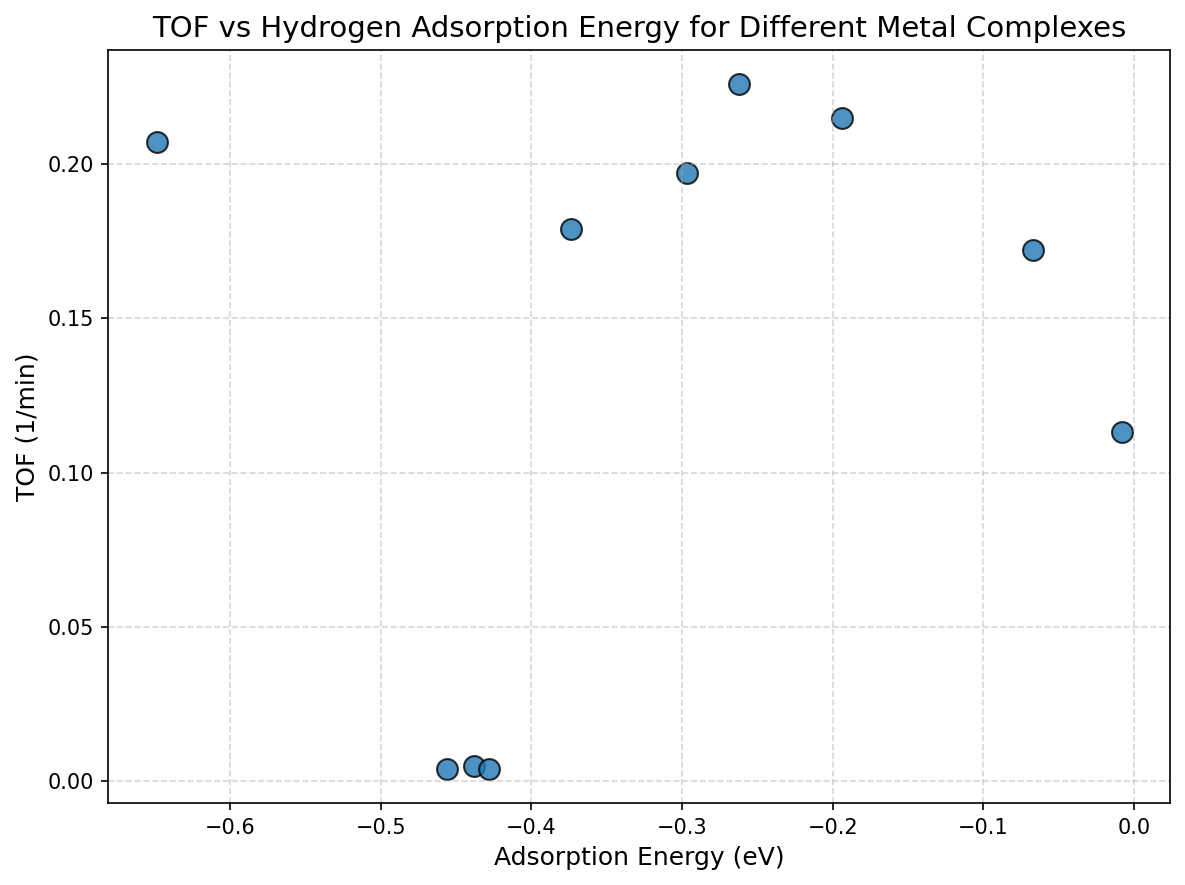

In [38]:
import matplotlib.pyplot as plt

# --- Prepare data ---
ligands = list(adsorption_energies.keys())
x = [adsorption_energies[l] for l in ligands]  # Adsorption energy (eV)
y = [tof[l] for l in ligands]                  # TOF (1/min)

# --- Create high-quality scatter plot ---
plt.figure(figsize=(8, 6), dpi=150)  # High resolution
plt.scatter(x, y, color='#1f77b4', s=100, edgecolors='k', alpha=0.8)  # Larger points with black edges

# Axes labels and title
plt.xlabel("Adsorption Energy (eV)", fontsize=12)
plt.ylabel("TOF (1/min)", fontsize=12)
plt.title("TOF vs Hydrogen Adsorption Energy for Different Metal Complexes", fontsize=14)

# Style
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


In [1]:
# # Summary of adsorption energies:
# {
#  'benzimidazole':-0.262,
#  '2_mercapto_6_methylpyridine':-0.295,
#  '6_mercaptonicotinonitrile':-1.616, # the hydrogens got desorped
#  '3_bromo_6_mercaptopyridine':-1.244, # the hydrogens got desorped
#  '3_aminopyridine_2_1H_thione':-0.935, # the hydrogens got desorped
#  '5_chloropyridine_2_thiol':-0.547,
#  "2-mercaptopyridine":-0.214,
#  '3_aminopyridine_2_1H_thione':-0.935, # the hydrogens got desorped
    
#  "3-5-benzenetricarboxylicacid": -1.650,
#  "5,7dichloro8hydroxyquinoline": -1.502,
#  "cyclohexanecarboxylicacid": -1.207,
# }